# 1. Introduction

Name: Matthew Ingram

Date: November 3, 2025

My project for this semester is to create an image classification model which can be given an input of an image of a food item (of various types), and then attempt to classify that food item.

This project uses a modified version of the "Food Image Classification Dataset" available on Kaggle at the following link:
https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset

The modifications of the dataset relate to making all of the food folders/directories have uniform naming conventions, stripping out underscores and converting all names to lowercase.

This project is based on the "Digit_Recognition.ipynb" lab.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # Convert to one-hot-encoding.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from os import listdir
from sklearn.preprocessing import LabelEncoder

sns.set(style='white', context='notebook', palette='deep')

# 2. Data Preparation

In [ ]:
# Unzip the zipped dataset.
import zipfile
with zipfile.ZipFile("/content/Food Dataset.zip", "r") as zipref:
  zipref.extractall("/content")

apple pie
350
baked potato
700
burger
1031
butter naan
1338
chai
1682
chapati
2009
cheesecake
2359
chicken curry
2709
chole bhature
3059
crispy chicken
3409
dal makhani
3704
dhokla
3949
donut
4299
fried rice
4649
fries
4999
hot dog
5349
ice cream
5699
idli
6001
jalebi
6289
kaathi rolls
6568
kadai paneer
6902
kulfi
7116
masala dosa
7389
momos
7712
omelette
8062
paani puri
8206
pakode
8475
pav bhaji
8780
pizza
9055
samosa
9299
sandwich
9649
sushi
9999
taco
10349
taquito
10699


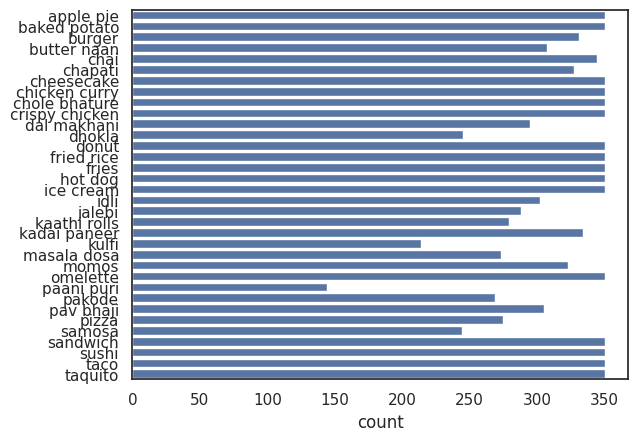

In [ ]:
# Load the data.
X_train = []
Y_train = []

food_types = ["apple pie", "baked potato", "burger", "butter naan", "chai",
              "chapati", "cheesecake", "chicken curry", "chole bhature", "crispy chicken",
              "dal makhani", "dhokla", "donut", "fried rice", "fries",
              "hot dog", "ice cream", "idli", "jalebi", "kaathi rolls",
              "kadai paneer", "kulfi", "masala dosa", "momos", "omelette",
              "paani puri", "pakode", "pav bhaji", "pizza", "samosa",
              "sandwich", "sushi", "taco", "taquito"]

# Sets a uniform size for all images, and sets a maximum amount of any class of image to prevent overrepresentation.
image_size = 100
food_count_allowed = 350

for food_type in food_types:
  current_food_count = 0
  print(food_type)

  for food_image in listdir("/content/Food Dataset/" + food_type):
    if current_food_count >= food_count_allowed:
      break
    current_food_count = current_food_count + 1
    Y_train.append(food_type)

    image_instance = cv2.imread("/content/Food Dataset/" + food_type + "/" + food_image)
    image_instance = cv2.cvtColor(image_instance, cv2.COLOR_BGR2RGB)
    image_instance = cv2.resize(image_instance, (image_size, image_size))

    X_train.append(image_instance)

  print(len(X_train))

class_count = len(food_types)

# Stack up lists into ndarrays.
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)

# Visualize the relative sizes of data for classes.
g = sns.countplot(Y_train)

# Normalize the data for faster convergence.
X_train = X_train / 255.0

In [ ]:
# Fit the Y training data to integer values based on alphabetical sorting, then convert those integers to one hot vectors for training.
# "burger" -> 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# "sushi" -> 31 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(Y_train)
Y_train = to_categorical(Y_train, num_classes = class_count)

In [ ]:
# Set the seed for randomization.
random_seed = 2

# Split the training and the validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train,
                                                  test_size = 0.1,
                                                  random_state = random_seed)

100


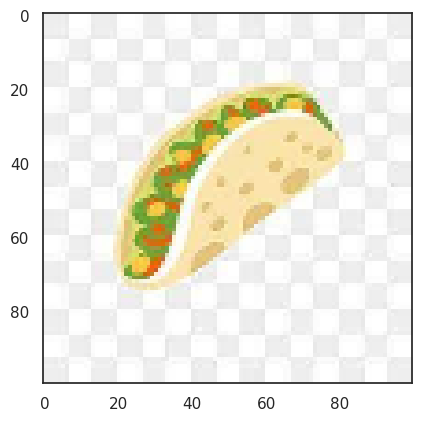

In [ ]:
# For checking various images.
image_to_show_index = input()
g = plt.imshow(X_train[int(image_to_show_index)][:,:,:])

# 3. CNN (Convolutional Neural Network)

In [ ]:
# Sets up the CNN model.
# The CNN layering that I went with is:
# [Conv2D(relu)]*3 -> MaxPool2D -> Dropout -> [Conv2D(relu)]*2 -> MaxPool2D -> Dropout -> Flatten -> Dense -> Dropout -> Output

model = Sequential()

model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'Same',
                 activation ='relu',
                 input_shape = (image_size, image_size, 3)))
model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64,
                 kernel_size = (5, 5),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation = "softmax"))

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.9, epsilon = 1e-08, weight_decay = 0.0),
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer, this one reduces learning rate as val_accuracy fails to improve.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.25,
                                            min_lr = 0.00001)

# Sets up epochs and batch_size for training.
epochs = 100
batch_size = 64

# Adds data augmentation to discourage the overfitting of data.
datagen = ImageDataGenerator(rotation_range = 10,  # Randomly rotates images in the range.
                             zoom_range = 0.1, # Randomly zooms image.
                             channel_shift_range = 0.05, # Randomly modifies color channels within range.
                             width_shift_range = 0.1,  # Randomly shifts images horizontally (fraction of total width).
                             height_shift_range = 0.1,  # Randomly shifts images vertically (fraction of total height).
                             horizontal_flip = True,  # Randomly flips images horizontally.
                             vertical_flip = False)  # Randomly flips images vertically.

datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val),
                              verbose = 2, steps_per_epoch = (X_train.shape[0] // batch_size),
                              callbacks = [learning_rate_reduction])

Epoch 1/100
150/150 - 74s - 494ms/step - accuracy: 0.0389 - loss: 4.4311 - val_accuracy: 0.0561 - val_loss: 3.4459 - learning_rate: 1.0000e-03
Epoch 2/100
150/150 - 1s - 7ms/step - accuracy: 0.0469 - loss: 3.5059 - val_accuracy: 0.0673 - val_loss: 3.4115 - learning_rate: 1.0000e-03
Epoch 3/100
150/150 - 39s - 259ms/step - accuracy: 0.0643 - loss: 3.3982 - val_accuracy: 0.0794 - val_loss: 3.3186 - learning_rate: 1.0000e-03
Epoch 4/100
150/150 - 1s - 7ms/step - accuracy: 0.1250 - loss: 3.3398 - val_accuracy: 0.0907 - val_loss: 3.2998 - learning_rate: 1.0000e-03
Epoch 5/100
150/150 - 37s - 246ms/step - accuracy: 0.0849 - loss: 3.2986 - val_accuracy: 0.1318 - val_loss: 3.1939 - learning_rate: 1.0000e-03
Epoch 6/100
150/150 - 1s - 7ms/step - accuracy: 0.1406 - loss: 3.2497 - val_accuracy: 0.1187 - val_loss: 3.1618 - learning_rate: 1.0000e-03
Epoch 7/100
150/150 - 37s - 248ms/step - accuracy: 0.1110 - loss: 3.2106 - val_accuracy: 0.1308 - val_loss: 3.1243 - learning_rate: 1.0000e-03
Epoch 8/

In [ ]:
model.save("/content/food_classification_model.keras")

# 4. Evaluate the model

In [ ]:
model = tf.keras.models.load_model("/content/food_classification_model.keras")

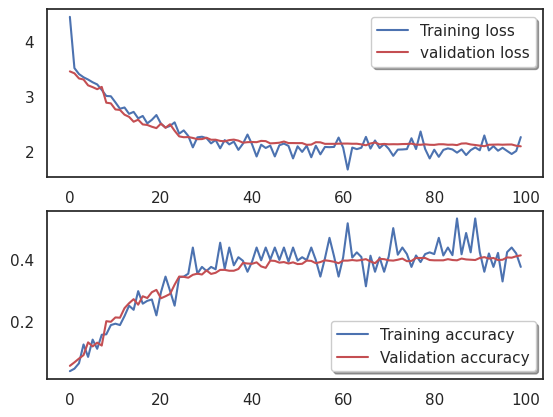

In [ ]:
# Plot the loss and accuracy curves for training and validation.

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step


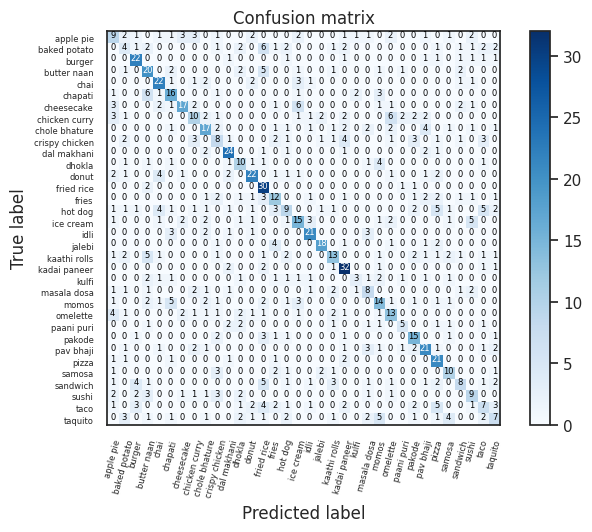

In [ ]:
# Confusion matrix, for showing what predicted labels correspond to the actual labels in training data.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize = 6)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.xticks(classes, food_types, rotation = 75, fontsize = 6)
    plt.yticks(classes, food_types, fontsize = 6)

# Predict the values from the validation dataset.
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors.
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convert validation observations to one hot vectors.
Y_true = np.argmax(Y_val, axis = 1)

# Compute the confusion matrix.
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix.
plot_confusion_matrix(confusion_mtx, classes = range(class_count))

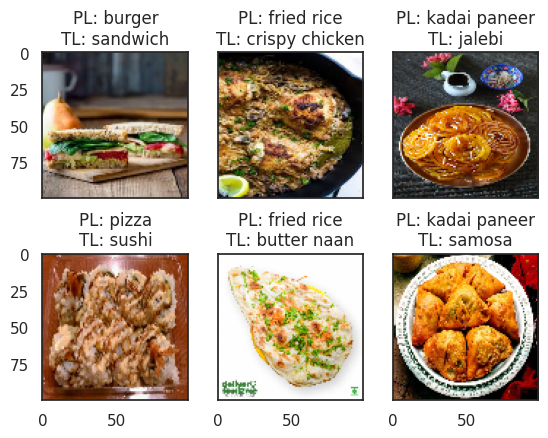

In [ ]:
# Display some error results.
# Errors are difference between predicted labels and true labels.
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,
                   img_errors,
                   pred_errors,
                   obs_errors):
    # This function shows 6 images with their predicted and real labels.
    # PL = Predicted label
    # TL = True label
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((image_size, image_size, 3)))
            ax[row,col].set_title("PL: {}\nTL: {}".format(food_types[pred_errors[error]], food_types[obs_errors[error]]))
            n += 1

# Probabilities of the wrong predicted numbers.
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set.
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis = 1))

# Difference between the probability of the predicted label and the true label.
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors.
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors.
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors.
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Please enter the path to the file you wish to classify (.jpg): /content/pizza.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
The model predicts that the image is of: pizza


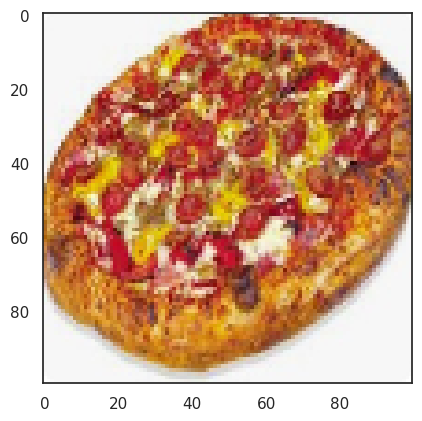

In [ ]:
# Interactive cell for testing new input images, enter the file path to the .jpg
# image you want to test, then the model will evaluate the image and give a prediction.
image_to_classify = input("Please enter the path to the file you wish to classify (.jpg): ")

classify_image = cv2.imread(image_to_classify)
classify_image = cv2.cvtColor(classify_image, cv2.COLOR_BGR2RGB)
classify_image = cv2.resize(classify_image, (image_size, image_size))

image_container = []
image_container.append(classify_image)
image_container = np.stack(image_container)

image_container = image_container / 255.0

result = model.predict(image_container)
print("The model predicts that the image is of:", food_types[np.argmax(result[0])])

g = plt.imshow(image_container[0][:,:,:])